## In this Jupyter Notebook, we train ML models using data from S3. This allows us to maintain high scalability with large compute resources. This notebook is divided into 3 sections: 

### 1. Import data from S3.

### 2. Train the ML model.

### 3. Convert the model with Tensorflow Lite to prepare it for the Arduino. Assess it with test data. 

#### Step 1. Here, we import data from the S3 bucket and display some of it. 

In [12]:
import math
import numpy as np
import boto3
from PIL import Image
from tensorflow.keras.utils import Sequence
import io

class S3DataGenerator(Sequence):
    def __init__(self, s3_client, bucket_name, parent_directory, batch_size, target_size, classes, shuffle=True):
        self.s3_client = s3_client
        self.bucket_name = bucket_name
        self.parent_directory = parent_directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.classes = classes
        self.shuffle = shuffle
        self.object_paths = self._get_object_paths()
        self.on_epoch_end()
    
    def _get_object_paths(self):
        object_paths = []
        for class_name in self.classes:
            response = self.s3_client.list_objects_v2(Bucket=self.bucket_name, Prefix=f"{self.parent_directory}{class_name}/")
            for obj in response.get('Contents', []):
                object_paths.append(obj['Key'])
        return object_paths

    def __len__(self):
        # Denotes the number of batches per epoch
        return math.ceil(len(self.object_paths) / self.batch_size)

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.object_paths[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.object_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialize lists to store data and labels
        X_list = []
        y_list = []
    
        # Generate data
        for ID in list_IDs_temp:
            valid_label = False
            label = -1
            for idx, class_name in enumerate(self.classes):
                if class_name in ID:
                    label = idx
                    valid_label = True
                    break
    
            # Skip if label is invalid
            if not valid_label:
                print(f"Skipping invalid ID: {ID}")
                continue
    
            # Load and process the image
            response = self.s3_client.get_object(Bucket=self.bucket_name, Key=ID)
            image = Image.open(io.BytesIO(response['Body'].read()))
            image = image.resize(self.target_size)
            image = np.array(image)
    
            # Scale images from [0, 255] to [-1, 1]
            image = image / 255.0
            image = image * 2 - 1
    
            # Append to lists
            X_list.append(image)
            y_list.append(label)
    
        # Convert lists to numpy arrays
        X = np.array(X_list)
        y = np.array(y_list, dtype=int)
    
        return X, y



In [13]:
s3_client = boto3.client('s3')
bucket_name = 'saltinedatabase'
parent_directory = 'crackers_raw/'
batch_size = 32
target_size = (224, 224)
classes = ['whole', 'broken']

train_generator = S3DataGenerator(s3_client, bucket_name, parent_directory, batch_size, target_size, classes)



In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def show_images(generator, num_images):
    # Get a batch of images
    batch_x, batch_y = next(iter(generator))
    
    # Create a grid with specified number of images
    plt.figure(figsize=(12, 10))  # Adjust the size as needed
    for i in tqdm(range(num_images)):
        ax = plt.subplot(5, 6, i + 1)  # Adjust the grid size as needed

        # Rescale the images from [-1, 1] back to [0, 255]
        img = ((batch_x[i] + 1) * 127.5).astype("uint8")
        
        plt.imshow(img)
        plt.title(generator.classes[batch_y[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


100%|██████████| 30/30 [00:00<00:00, 93.93it/s]


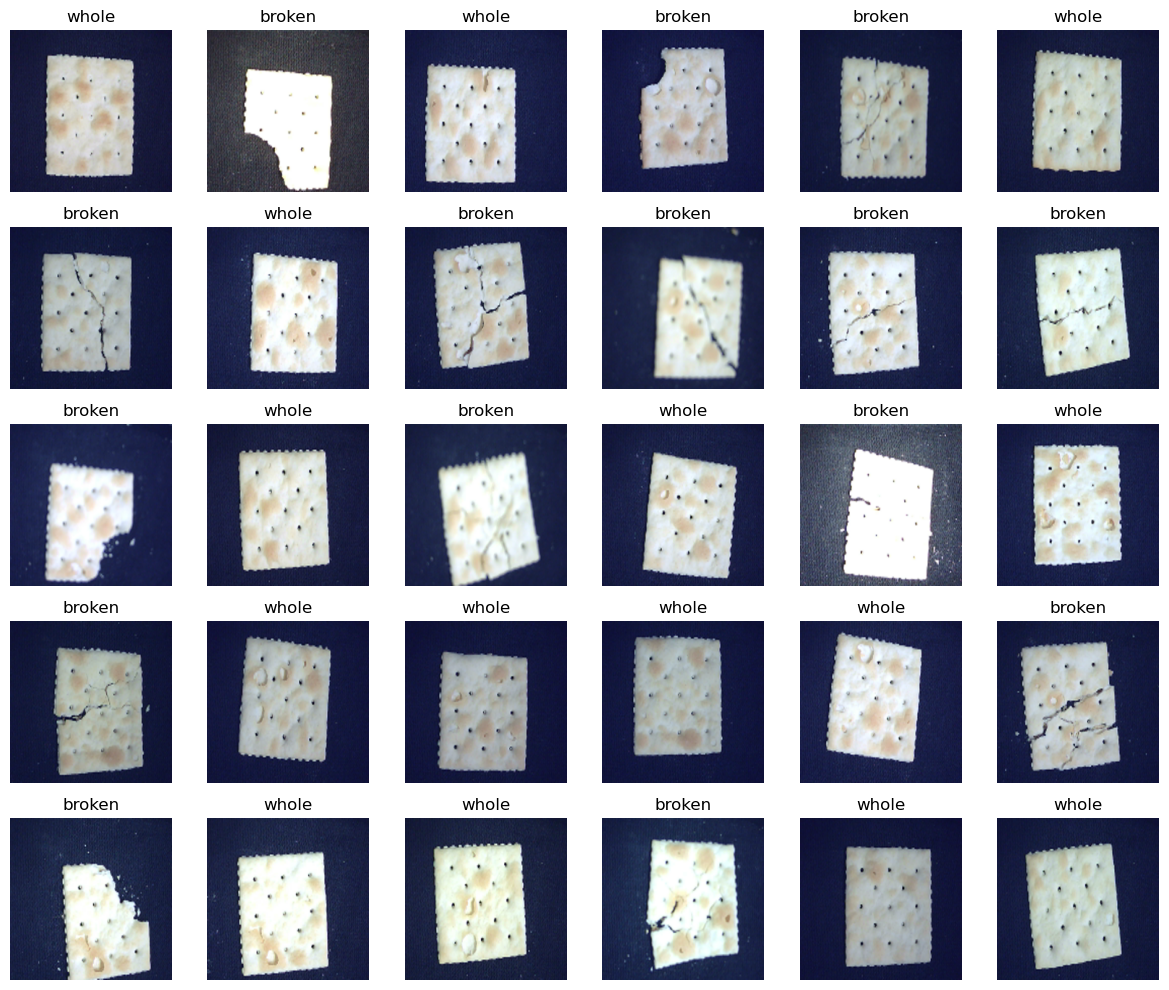

In [15]:
# Display 30 images from the dataset
show_images(train_generator, 30)


### Step 2. Train a MobileNetv2 Model. We start by creating the model. 

In [16]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf

# Constants
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_HEIGHT = 224
num_classes = 2 

# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)
base_model.trainable = False

# Augmentation layers
augmen = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
])

# Model building
inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
x = augmen(inputs)  # Apply augmentations
x = base_model(x, training=False)  # Pass augmented inputs through base_model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, 7, 7, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562

In [17]:
x, y = next(iter(train_generator))
print("Sample image shape:", x[0].shape)
print("Sample label:", y[0])
all_labels = []
for _, labels in train_generator:
    all_labels.extend(labels)
print("Unique label values in the dataset:", np.unique(all_labels))



Sample image shape: (224, 224, 3)
Sample label: 0
Unique label values in the dataset: [0 1]


### Next, we train the Model.

In [20]:
from tensorflow.keras.optimizers import Adam


lr = 10**-2
opt_f = tf.keras.optimizers.Adam(learning_rate=lr)
loss_f = tf.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(
  optimizer=opt_f,
  loss=loss_f,
  metrics=['accuracy'])


In [21]:

epochs = 8
history = model.fit(train_generator, epochs=epochs)

Epoch 1/8


2024-01-04 04:01:52.877760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 4s 4s/step - loss: 0.2357 - accuracy: 0.8476
Epoch 2/8
1/1 [==============================] - 1s 1s/step - loss: 0.1975 - accuracy: 0.8653
Epoch 3/8
1/1 [==============================] - 1s 1s/step - loss: 0.1834 - accuracy: 0.8927
Epoch 4/8
1/1 [==============================] - 1s 1s/step - loss: 0.1462 - accuracy: 0.9099
Epoch 5/8
1/1 [==============================] - 1s 1s/step - loss: 0.1213 - accuracy: 0.9245
Epoch 6/8
1/1 [==============================] - 1s 1s/step - loss: 0.0987 - accuracy: 0.9521
Epoch 7/8
1/1 [==============================] - 1s 1s/step - loss: 0.0765 - accuracy: 0.9778
Epoch 8/8
1/1 [==============================] - 1s 1s/step - loss: 0.0634 - accuracy: 0.9834


#### Save the model

In [29]:
from datetime import datetime

def save_model_with_timestamp(model, base_filename="mobilenetv2"):
    """Saves the given Keras model with a timestamp.

    Args:
    model: Keras model to be saved.
    base_filename: Base filename for the model, default is 'mobilenetv2'.
    """
    # Get the current date and time
    current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Construct the filename with the datetime
    model_filename = f"{base_filename}_{current_datetime}"

    # Save the model
    model.save(model_filename)

    return model_filename


TF_MODEL = save_model_with_timestamp(model, "mobilenetv2")
TFL_MODEL_FILE = TF_MODEL +"tflite"
TFL_MODEL_HEADER_FILE = TF_MODEL + ".h"
print(f"Model saved as {TF_MODEL}")

2024-01-04 04:10:06.664463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_rotation_2_input' with dtype float and shape [?,224,224,3]
	 [[{{node random_rotation_2_input}}]]
2024-01-04 04:10:06.720702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2024-01-04 04:10:06.730291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_rotation_2_input' with dtype

INFO:tensorflow:Assets written to: mobilenetv2_20240104_041006/assets


INFO:tensorflow:Assets written to: mobilenetv2_20240104_041006/assets


Model saved as mobilenetv2_20240104_041006


### Step 3. Prepare the model with Tensorflow Lite for the Arduino

In [30]:
#Test generator
s3_client = boto3.client('s3')
bucket_name = 'saltinedatabase'
parent_directory = 'crackers_test/'
batch_size = 32
target_size = (224, 224)
classes = ['whole', 'broken']

test_generator = S3DataGenerator(s3_client, bucket_name, parent_directory, batch_size, target_size, classes)

# Convert the model to TensorFlow Lite format with quantization
def representative_data_gen():
    for input_data, _ in test_generator:
        # Ensure the input data is of type float32
        input_data = input_data.astype(np.float32)
        yield [input_data]


converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tfl_model = converter.convert()




2024-01-04 04:10:42.401528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-04 04:10:42.401572: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-04 04:10:42.401793: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: mobilenetv2_20240104_041006
2024-01-04 04:10:42.430907: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-01-04 04:10:42.430949: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: mobilenetv2_20240104_041006
2024-01-04 04:10:42.521761: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-04 04:10:42.972506: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: mobilenetv2_20240104_041006
2024-01-04 04:10:43.138442: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; 

In [31]:
interp = tf.lite.Interpreter(model_content=tfl_model)
interp.allocate_tensors()

i_details = interp.get_input_details()[0]
o_details = interp.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
i_scale = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]

num_correct_samples = 0
num_samples = 0

for input_data, actual_label in test_generator:
    # Ensure we process one sample at a time
    for i in range(input_data.shape[0]):
        single_input_data = input_data[i:i+1]  # Get one sample
        single_input_data = (single_input_data / i_scale) + i_zero_point
        single_input_data = tf.cast(single_input_data, dtype=tf.int8)
        
        interp.set_tensor(i_details["index"], single_input_data.numpy())
        interp.invoke()
        predicted_output = interp.get_tensor(o_details["index"])[0]

        if np.argmax(predicted_output) == actual_label[i]:
            num_correct_samples += 1
    
    num_samples += input_data.shape[0]

accuracy = num_correct_samples / num_samples
print("Accuracy:", accuracy)


Accuracy: 0.9801394


In [32]:
open(TFL_MODEL_FILE, "wb").write(tfl_model)

624792

In [33]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i $TFL_MODEL_FILE > $TFL_MODEL_HEADER_FILE
!sed -i 's/unsigned char/const unsigned char/g' $TFL_MODEL_HEADER_FILE
!sed -i 's/const/alignas(8) const/g' $TFL_MODEL_HEADER_FILE

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
/bin/bash: line 1: xxd: command not found


In [34]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

624792 bytes


#### Save the model back to S3 so that it is ready for deployment

In [35]:
import boto3
from botocore.exceptions import NoCredentialsError

def upload_to_s3(local_file, bucket, s3_file):
    """
    Upload a file to an S3 bucket

    :param local_file: File to upload
    :param bucket: Bucket to upload to
    :param s3_file: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """
    # Create an S3 client
    s3 = boto3.client('s3')

    try:
        # Upload the file
        s3.upload_file(local_file, bucket, s3_file)
        print(f"File {local_file} uploaded to {s3_file} in bucket {bucket}.")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False

# File and bucket details
local_file_name = TFL_MODEL_HEADER_FILE
bucket_name = 'saltinedatabase'  # Replace with your bucket name
s3_file_name = f"models/{TFL_MODEL_HEADER_FILE}"

# Upload the file
upload_to_s3(local_file_name, bucket_name, s3_file_name)


File mobilenetv2_20240104_041006.h uploaded to models/mobilenetv2_20240104_041006.h in bucket saltinedatabase.


True